3-adic Eisenstein Extension Field in y defined by x^2 - 3
D matrix:  2.62 sec
a=0, Tau matrix:  0.45 sec
a=0, s=49:  0.17 sec
a=1, Tau matrix:  0.46 sec
a=1, s=49:  0.19 sec


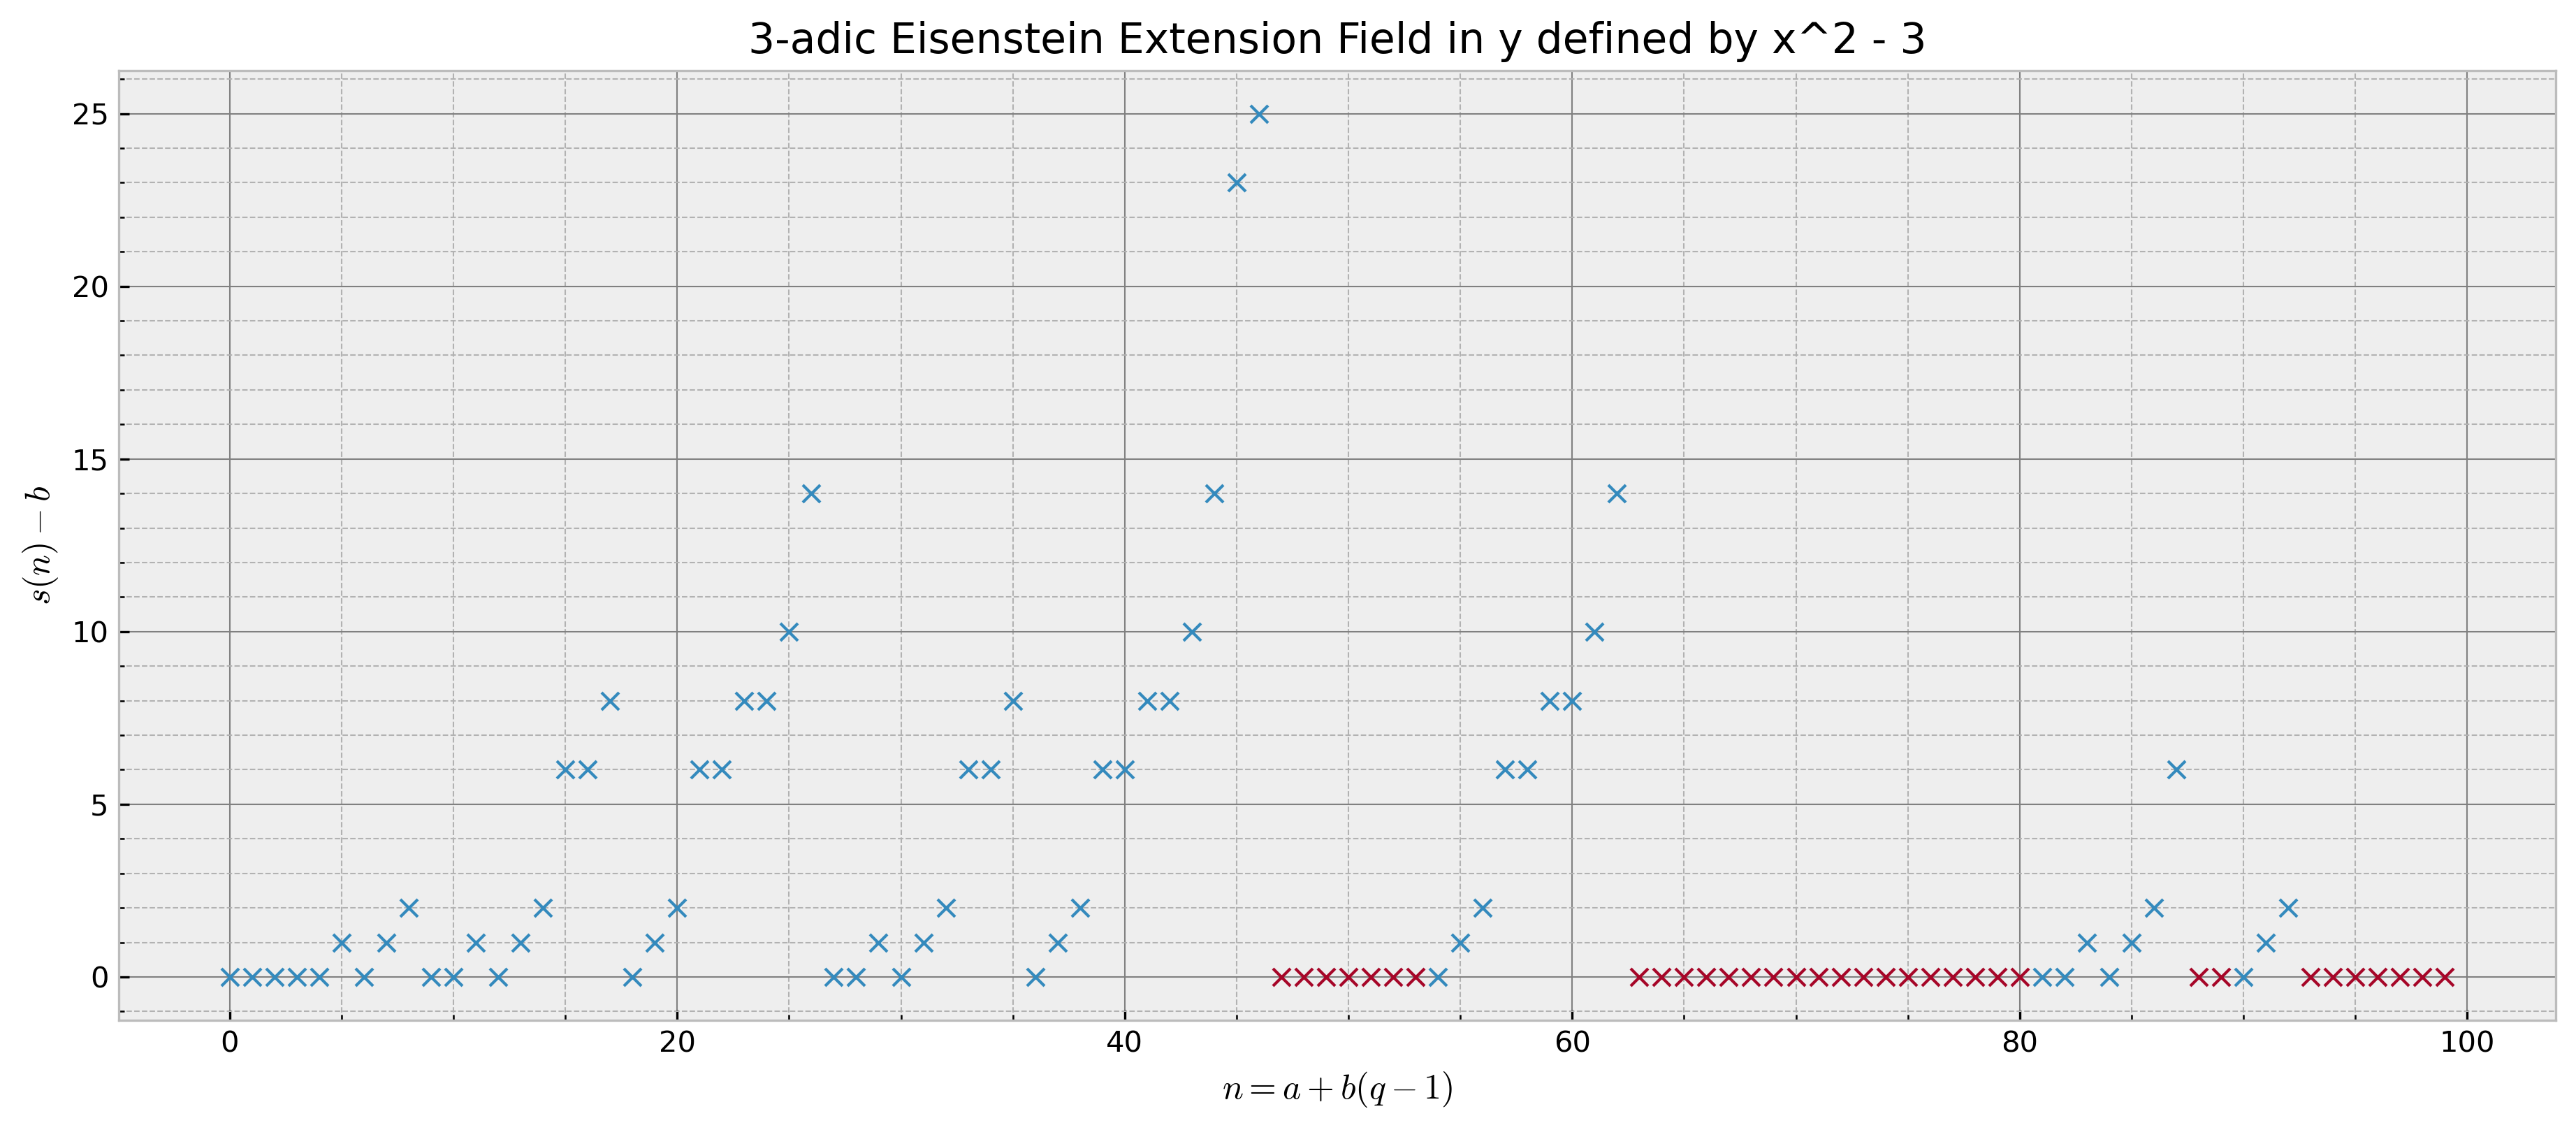

In [1]:
extension = "3,2,100,ram"  # Choose the extension to compute with
precision = 1000           # Choose the precision that Sage will use

parse = extension.split(',')
p = int(parse[0])  # Prime to calculate with
d = int(parse[1])  # Degree to calculate with
N = int(parse[2])  # Cutoff; must be divisible by q-1
ram = parse[3]


# Python imports
from time import process_time
import matplotlib.pyplot as plt
import numpy as np

# Definitions
from sage.rings.padics.padic_generic import ResidueLiftingMap
from sage.rings.padics.padic_generic import ResidueReductionMap
import sage.rings.padics.padic_extension_generic

power = p^d - 1
t_poly = ""

if ram == "ram":
    t_poly = f"x^{d}-{p}"
else:
    # generate poly for unramified case
    Fp = GF(p)
    Fp_t.<t> = PolynomialRing(Fp)
    unity_poly = t^(power) - 1
    factored = unity_poly.factor()
    factored_str = str(factored)
    start = factored_str.find("^"+str(d))
    last_brac_pos = factored_str.find(")",start)
    first_brac_pos = len(factored_str) \
                     - factored_str[::-1].find("(",len(factored_str)-start)
    t_poly = factored_str[first_brac_pos:last_brac_pos].replace('t','x')


# Define the polynomial to adjoin a root from
Q_p = Qp(p,precision)
R_Qp.<x> = PolynomialRing(Q_p)
f_poly = R_Qp(t_poly)

# Define the p-adic field, its ring of integers and its residue field
# These dummy objects are a workaround to force the precision wanted
dummy1.<y> = Zp(p).ext(f_poly)
dummy2.<y> = Qp(p).ext(f_poly)

o_L.<y> = dummy1.change(prec=precision)
L.<y> = dummy2.change(prec=precision)
k_L = L.residue_field()
print(L)

# Find the generator of the unique maximal ideal in o_L. 
Pi = o_L.uniformizer()

# Find f, e and q
f = k_L.degree()             # The degree of the residual field extension
e = L.degree()/k_L.degree()  # The ramification index
q = p^f

# Do linear algebra over the ring of polynomials L[X]
# in one variable X with coefficients in the field L:
L_X.<X> = L[]
L_Y.<Y> = L[]

v = L.valuation()
    
# The subroutine Dmatrix calculates the following sparse matrix of coefficients.
# Let D[k,n] be equal to k! times the coefficient of Y^k in the polynomial P_n(Y). 
# I compute this using the useful and easy recursion formula 
#      D[k,n] = \sum_{r \geq 0} \pi^{-r} D[k-1,n-q^r] 
# that can be derived from Laurent’s Prop 1.20 of "outline9".
# The algorithm is as follows: first make a zero matrix with S rows and columns 
# (roughly, S is (q-1)*Size), then quickly populate it one row at a time,
# using the recursion formula.
def Dmatrix(S):
    D = matrix(L, S,S)
    D[0,0] = 1
    for k in range(1,S):
        for n in range(k,S):
            r = 0
            while n >= q^r:
                D[k,n] = D[k,n] + D[k-1,n-q^r]/Pi^r  # the actual recursion 
                r = r+1
    return D


# \Tau^{(m)} in Definition 10.10 of "bounded21":
def TauMatrix(Size, m, D=None):
    if D is None:
        D = Dmatrix((q - 1) * (Size + 1))
    R = matrix(L, Size,Size, lambda x,y: D[m + (q-1)*x, m + (q-1)*y])

    # Define a diagonal matrix:
    Diag = matrix(L_X, Size,Size, lambda x,y: kronecker_delta(x,y) * X^x)

    # Compute the inverse of R:
    S = R.inverse()
    
    # Compute the matrix Tau using Lemma 10.11 in "bounded21":
    Tau = S * Diag * R
    
    return Tau

def underscore(m, i):
    return m + i*(q-1)

def w_q(n):
    return (n - sum(n.digits(base=q))) / (q-1)

def compute_s(N, filename=None):
    assert N%(q-1) == 0
    
    t_start = process_time()
    D = Dmatrix(N)
    t_end = process_time()
    print(f"D matrix: {t_end-t_start : .2f} sec")
        
    s0 = [-1 for _ in range(N)]
    
    for a in range(q-1):
        t_start = process_time()
        Tau_a = TauMatrix(N//(q-1), a, D)
        t_end = process_time()
        print(f"a={a}, Tau matrix: {t_end-t_start : .2f} sec")
        
        B_old = Matrix(0,0)
        d = 0
        for s in range(N // (q-1)):
            t_start = process_time()
            
            # 1. Use the non-zero rows from previous calculations
            # 2. Add a 0 column to its left
            # 3. Add rows corresponding to entries from the j_th column of Tau_a
            B = Matrix(L, 2*s-d+1, s-d+1)
            B[:s-d, 1:] = B_old
            for i in [0 .. s]:
                coeffs = Tau_a[i, s].list()
                B[s-d+i, B.ncols()-len(coeffs)+d:] = vector(L, reversed(coeffs[d:]))
            
            # Perform Gaussian elimination
            i0 = 0
            ks = []
            for k in range(B.ncols()):
                valuation_row_pairs = [ 
                    (v(B[i,k]), i) for i in range(i0, B.nrows()) if B[i,k] != 0]

                # If we have a zero column, move on to the next one
                if not valuation_row_pairs:
                    continue
                minv, i_minv = min(valuation_row_pairs)
                ks.append(k)

                # Swap the row of minimum valuation with the first bad row
                B[i0, :], B[i_minv, :] = B[i_minv, :], B[i0, :]

                # Divide the top row by a unit in o_L
                u = B[i0, k] / Pi^int(e * v(B[i0, k]))
                B[i0, :] /= u

                # Cleave through the other rows
                for i in range(B.nrows()):
                    if i != i0 and v(B[i, k]) >= v(B[i0, k]):
                        B[i, :] -= B[i, k]/B[i0, k] * B[i0, :]

                i0 += 1
            
            d_is_updated = False
            for b in [d .. s]:
                n = a + b*(q-1)
                if v(B[s-b, s-b]) * e == -w_q(n): 
                    if s0[n] == -1:
                        s0[n] = s
                else:
                    if not d_is_updated:
                        d = b
                        d_is_updated = True
            B_old = B[:s-d+1, :s-d+1]
            
            t_end = process_time()
            print(f"a={a}, s={s}: {t_end-t_start : .2f} sec", end='\r')
            if filename is not None:
                with open(filename, 'w') as f:
                    f.write("n, s\n")
                    for n, s in enumerate(j_0s):
                        f.write(f"{n}, {s}\n")
        print()

    plt.style.use('bmh')
    fig = plt.figure(figsize=(15,6), dpi=300)
    for n, s in enumerate(s0):
        if s != -1:
            b = n // (q-1)
            plt.plot(n, s-b, 'x', c='C0')
        else:
            plt.plot(n, 0, 'x', c='C1')
    plt.xlabel(r"$n = a + b(q-1)$")
    plt.ylabel("$s(n) - b$")
    plt.title(str(L))
    plt.minorticks_on()
    plt.grid(which='both')
    plt.grid(which='major', linestyle='-', c='grey')
    
    return s0, fig


s0 = compute_s(N);
